In [21]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor,
    RandomForestClassifier,
    HistGradientBoostingClassifier
)

from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    train_test_split,
    cross_validate,
    cross_val_score
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    f1_score,
    roc_auc_score,
    roc_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import joblib
import os
import matplotlib.image as mpimg
import math


In [18]:
main_df = pd.read_csv('../data/processed/datasets_merged_cleaned.csv')

main_df['fecha'] = pd.to_datetime(main_df['anio'].astype(str) + '-' + main_df['mes'].astype(str), format='%Y-%m')
unique_cadenas = set([(a,b) for a,b in main_df[['cadena_id', 'cadena']].values])

# Guarda en disco el modelo en formato joblib para su posterior uso.
def guardar_modelo(modelo, filename):
    path = os.path.join('../models', filename)
    
    try: os.makedirs(os.path.dirname(path))
    except: pass

    joblib.dump(modelo, path)

# carga un modelo desde disco
def cargar_modelo(filename):
    path = os.path.join('../models', filename)
    
    if os.path.exists(path): return joblib.load(path)
    return None

# Guarda la curva ROC en disco
def guardar_roc_curve(y_test, scores, name, score):
    # Curva ROC y gráfico
    fpr, tpr, thr = roc_curve(y_test, scores)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={score:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC — {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"../models/clasificacion/roc_curve/ROC_{name}.png", dpi=130)
    plt.close()

REGRESION

In [4]:
calcular_rmse = lambda y_test, y_pred: np.sqrt(mean_squared_error(y_test, y_pred))
calcular_mae = lambda y_test, y_pred: mean_absolute_error(y_test, y_pred)
calcular_wmape = lambda y_test, y_pred: np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))

# Iterador, genera una tupla (cadena, X, y).
def iter_regresion_Xy():
	# Las regresiones se harán en grupos separados por cadena de supermercados, ya que se quiere evitar
	# la influencia de los precios de una cadena sobre los de otra. Usualmente una misma cadena oscila sus
	# precios de forma regular.
	for cadena_id,cadena_name in unique_cadenas:
		df = main_df[main_df.cadena_id == cadena_id]
		
		# Ya fueron codificadas previamente las variables categóricas, por lo que se utilizan sus ids directamente.
		X = df[['supermercado_id', 'cadena_id', 'producto_id']]
		y = df['costo']
		
		yield cadena_name, X, y

# Listado de todos los modelos de regresión que se utilizarán para el análisis.
all_regresion = {
    'Baseline': DummyRegressor(strategy='mean'),
    'Ridge': Ridge(alpha=1.0, max_iter=10000),
    'RandomForest': RandomForestRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
}

metricas = []

for cadena_name, X, y in iter_regresion_Xy():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for reg_nombre, reg in all_regresion.items():
        modelo = Pipeline([
            ('scaler', StandardScaler()),
            ('regresion', reg),
        ])
        
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
                
        guardar_modelo(modelo, 'regresion/{} - {}.joblib'.format(cadena_name, reg_nombre))
        
		# Cálculo de las métricas MAE, RMSE y WMAPE
        mae = calcular_mae(y_test, y_pred)
        rmse = calcular_rmse(y_test, y_pred)
        wmape = calcular_wmape(y_test, y_pred)

        metricas.append({
            'cadena': cadena_name,
            'regresion': reg_nombre,
            'MAE': mae,
            'RMSE': rmse,
            'WMAPE': wmape,
        })
    
metricas = pd.DataFrame(metricas)
display(metricas)
    

,cadena,regresion,MAE,RMSE,WMAPE
0,REY,Baseline,1.734796,2.398614,0.680238
1,REY,Ridge,1.725760,2.399960,0.676694
2,REY,RandomForest,0.202768,0.422720,0.079508
3,REY,HistGradientBoosting,0.224354,0.424481,0.087972
4,SUPER 99,Baseline,1.678521,2.306151,0.664752
5,SUPER 99,Ridge,1.657792,2.298910,0.656543
6,SUPER 99,RandomForest,0.196611,0.395333,0.077865
7,SUPER 99,HistGradientBoosting,0.224051,0.401797,0.088732
8,XTRA,Baseline,1.655357,2.291133,0.663192
9,XTRA,Ridge,1.646002,2.290072,0.659444


REGRESION - VALIDACION CRUZADA

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
regresion_scores = pd.DataFrame()

# Utiliza el iterador para volver a obtener (cadena, X, y).
for cadena_name, X, y in iter_regresion_Xy():
    puntajes = []
    
	# Se realizará una validación cruzada de los modelos de regresión que se seleccionaron.
    for reg_nombre, reg in all_regresion.items():
        modelo = Pipeline([
            ('scaler', StandardScaler()),
            ('regresion', reg),
        ])
        
        scores = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_absolute_error')
        
        puntajes.append({
            'cadena': cadena_name,
            'regresion': reg_nombre,
            'MAE score': -np.mean(scores)
        })
    
	# Se utiliza la métrica MAE para evaluar el mejor modelo.
	# El mejor puntaje es aquel cuya MAE sea menor.
    puntajes = pd.DataFrame(puntajes)
    puntajes['mejor'] = puntajes['MAE score'] == puntajes['MAE score'].min()
    regresion_scores = pd.concat([regresion_scores, puntajes])

display(regresion_scores)        

,cadena,regresion,MAE score,mejor
0,REY,Baseline,1.708986,False
1,REY,Ridge,1.698376,False
2,REY,RandomForest,0.200306,True
3,REY,HistGradientBoosting,0.227926,False
0,SUPER 99,Baseline,1.692998,False
1,SUPER 99,Ridge,1.674551,False
2,SUPER 99,RandomForest,0.200642,True
3,SUPER 99,HistGradientBoosting,0.228443,False
0,XTRA,Baseline,1.658579,False
1,XTRA,Ridge,1.646154,False


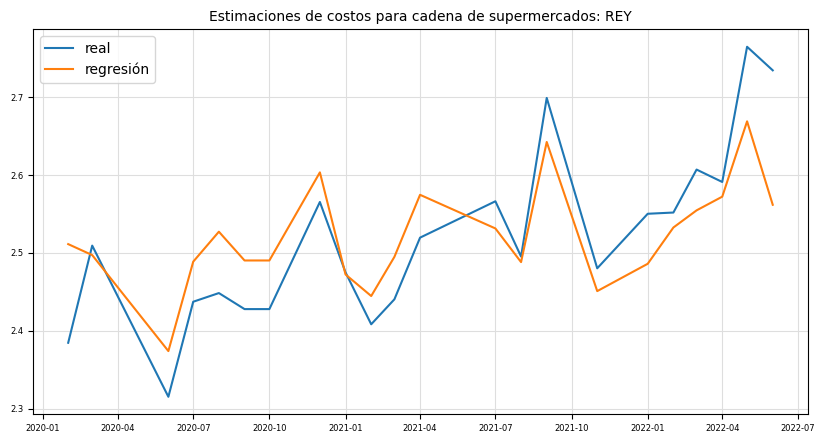

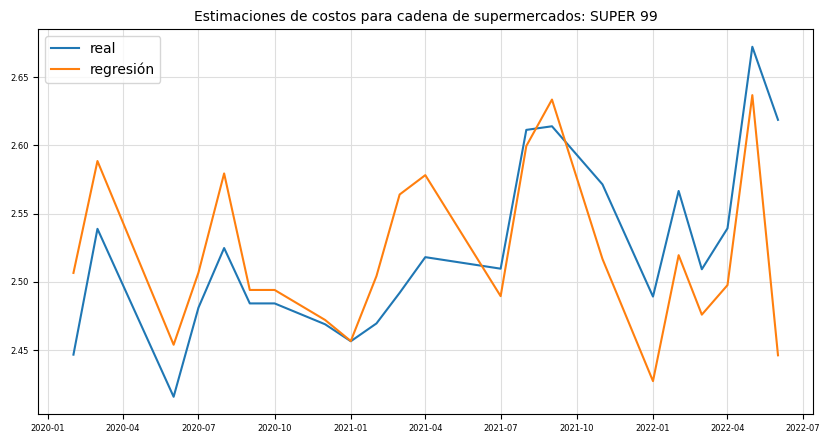

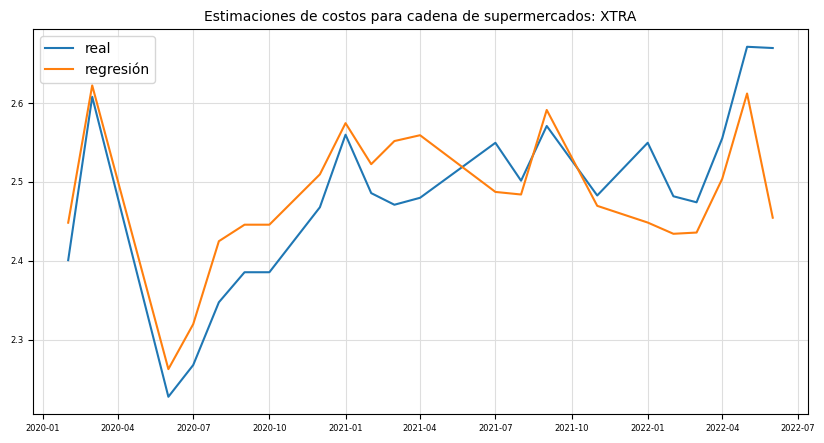

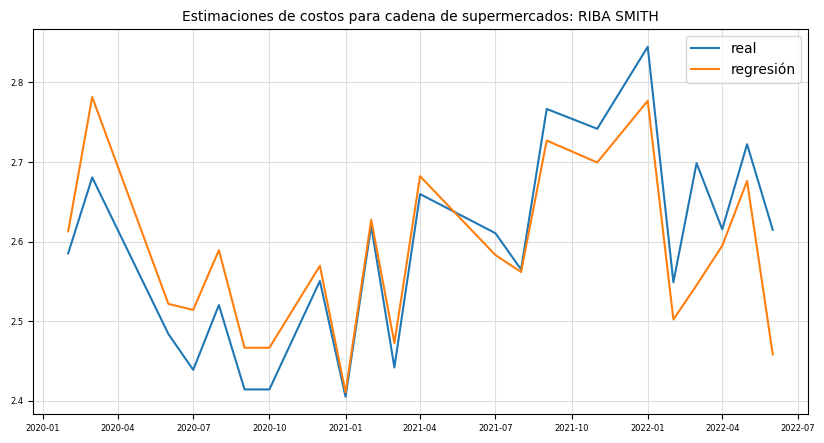

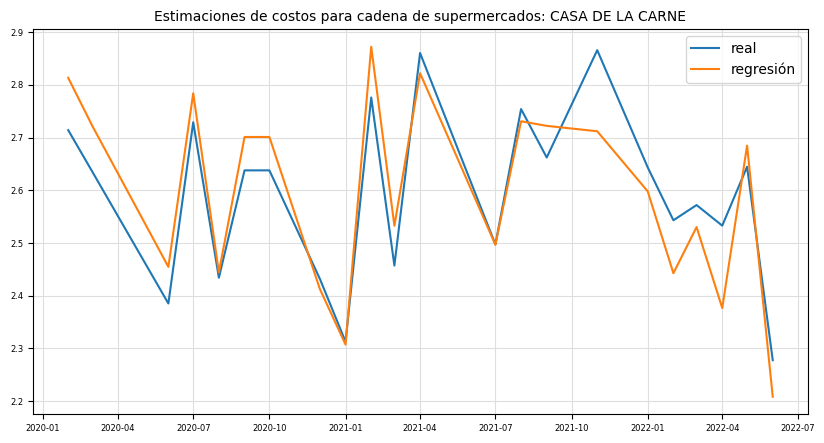

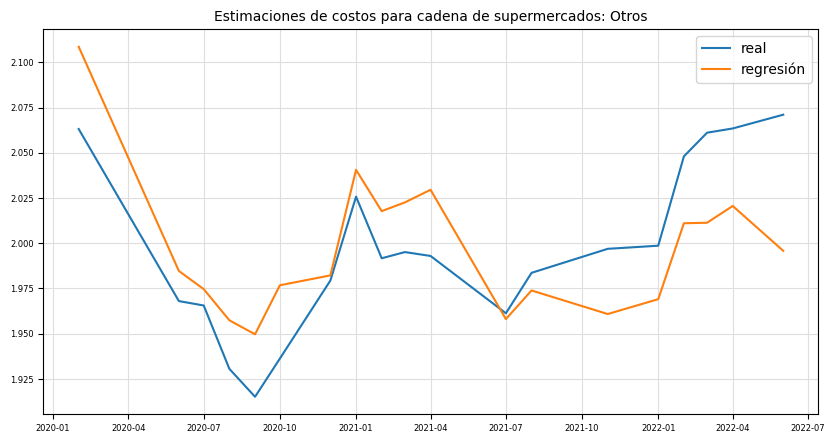

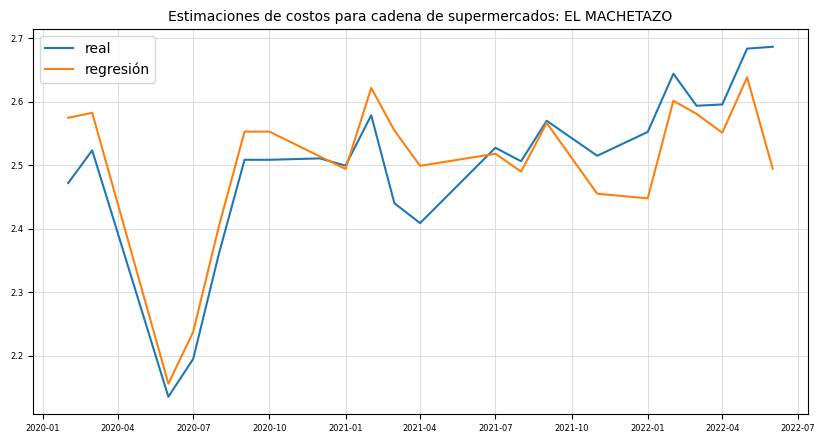

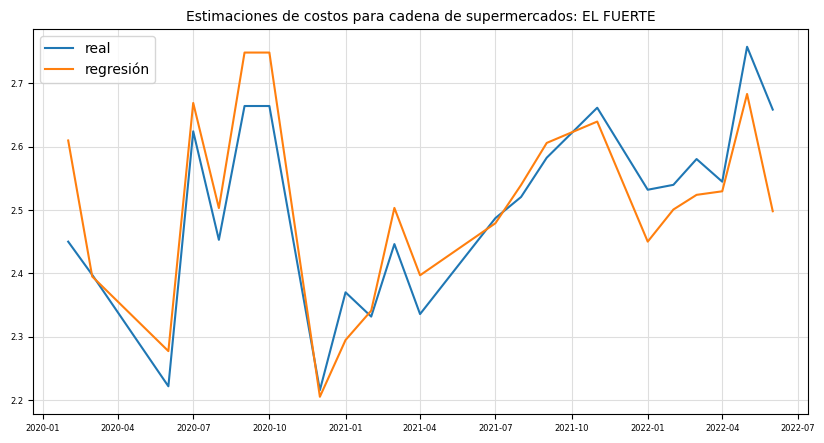

In [6]:
#Graficar los mejores modelos de regresión para cada cadena.
mejores_modelos = regresion_scores[regresion_scores.mejor == True][['cadena', 'regresion']]

for cadena, regresion in mejores_modelos.values:
    # Se carga el modelo previamente guardado en disco
    modelo = cargar_modelo('regresion/{} - {}.joblib'.format(cadena, regresion))
    
    if modelo:
        df = main_df[main_df.cadena == cadena]
        y_pred = modelo.predict(df[['supermercado_id', 'cadena_id', 'producto_id']])

        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title('Estimaciones de costos para cadena de supermercados: %s' % cadena, fontsize=10)
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.grid(True, color='#dedede')
        
        for x,y,label in [(df.fecha, df.costo, 'real'), (df.fecha, y_pred, 'regresión')]:
            df = pd.DataFrame({'fecha':x, 'costo':y}).groupby(['fecha'])['costo'].mean().reset_index()
            ax.plot(df.fecha, df.costo, label=label)

    plt.legend()
    plt.show()

CLASIFICACION

In [20]:
# Similar a la regresión, se crea un iterador que genera una tupla (cadena, X, y).
def iter_clasificacion_Xy():
    for cadena_id, cadena_name in unique_cadenas:
        df = main_df[main_df.cadena_id == cadena_id][['supermercado_id', 'cadena_id', 'producto_id', 'costo', 'fecha']]
        df = df.sort_values('fecha')

        umbral = df['costo'].median()

        df['target'] = (umbral < df['costo']).astype(int)
        X = df[['supermercado_id', 'cadena_id', 'producto_id']]
        y = df['target']

        yield cadena_name, X, y

# Se enlistan los modelos de clasificación que se utilizarán en el análisis.
all_clasificacion = {
    'Baseline': DummyClassifier(strategy="stratified", random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42)
}

metricas = []

for cadena_name, X, y in iter_clasificacion_Xy():
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    
    for cls_nombre, cls in all_clasificacion.items():
        modelo = Pipeline([
            ('scaler', StandardScaler()),
            ('clasificador', cls),
        ])
        
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        
        # Se guarda el modelo en disco.
        guardar_modelo(modelo, 'clasificacion/{} - {}.joblib'.format(cadena_name, cls_nombre))
        
        # Algunos modelos generan probabilidades, por lo que hay que verificar cuáles lo hacen.
        if hasattr(modelo.named_steps["clasificador"], "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        elif hasattr(modelo.named_steps["clasificador"], "decision_function"):
            y_proba = modelo.decision_function(X_test)
        else:
            y_proba = None

        f1 = f1_score(y_test, y_pred, average='macro')
        roc_auc = None if y_proba is None else roc_auc_score(y_test, y_proba)
        pr_auc = None if y_proba is None else average_precision_score(y_test, y_proba)
        
        metricas.append({
            'cadena': cadena_name,
            'clasificador': cls_nombre,
            'F1': f1,
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc,
        })
        
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        guardar_roc_curve(y_test, y_proba, f"{cadena_name}_{cls_nombre}", roc_auc)

metricas = pd.DataFrame(metricas)
display(metricas)

,cadena,clasificador,F1,ROC-AUC,PR-AUC
0,REY,Baseline,0.498795,0.498840,0.491702
1,REY,LogisticRegression,0.547465,0.604435,0.619188
2,REY,RandomForest,0.975057,0.997249,0.997132
3,REY,HistGradientBoosting,0.975058,0.998028,0.997879
4,SUPER 99,Baseline,0.498848,0.498851,0.497254
5,SUPER 99,LogisticRegression,0.564000,0.609667,0.624157
6,SUPER 99,RandomForest,0.965499,0.993886,0.992186
7,SUPER 99,HistGradientBoosting,0.965241,0.996119,0.996082
8,XTRA,Baseline,0.491991,0.492018,0.493938
9,XTRA,LogisticRegression,0.553361,0.615738,0.625184


CLASIFICACION - VALIDACION CRUZADA

In [12]:
# Validación cruzada para los modelos de clasificación.
# Resumen automático del mejor modelo por cada cadena
mejores_modelos = clasificacion_scores[clasificacion_scores["mejor"]]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clasificacion_scores = pd.DataFrame()

# Los puntajes estarán basados en las métricas F1 obligatorio, ROC-AUC y PR-AUC
scoring = {
    'f1_macro': 'f1_macro',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'  # PR-AUC
}

for cadena_name, X, y in iter_clasificacion_Xy():
    puntajes = []
    
    for cls_nombre, cls in all_clasificacion.items():
        scores = cross_validate(cls, X, y, cv=cv, scoring=scoring, return_train_score=False)
        
        puntajes.append({
            'cadena': cadena_name,
            'clasificador': cls_nombre,
            'F1 score': np.mean(scores['test_f1_macro']),
            'ROC-AUC score': np.mean(scores['test_roc_auc']),
            'PR-AUC score': np.mean(scores['test_pr_auc'])
        })
    
	# Se utiliza F1 como métrica para determinar el mejor modelo. Esto debido a que el objetivo de la clasificación
    # es determinar si el costo subirá o no de valor al siguiente mes. Para dicho análisis, F1 es la mejor opción.
    # Mientras más alto el valor F1, mejor.
    puntajes = pd.DataFrame(puntajes)
    puntajes['mejor'] = puntajes['F1 score'] == puntajes['F1 score'].max()
    clasificacion_scores = pd.concat([clasificacion_scores, puntajes])

display(clasificacion_scores)

,cadena,clasificador,F1 score,ROC-AUC score,PR-AUC score,mejor
0,REY,Baseline,0.491431,0.491470,0.488503,False
1,REY,LogisticRegression,0.543177,0.593382,0.602552,False
2,REY,RandomForest,0.968525,0.995449,0.993726,False
3,REY,HistGradientBoosting,0.970662,0.997245,0.997042,True
0,SUPER 99,Baseline,0.501788,0.501790,0.498925,False
1,SUPER 99,LogisticRegression,0.571022,0.613350,0.628533,False
2,SUPER 99,RandomForest,0.964883,0.994566,0.993439,True
3,SUPER 99,HistGradientBoosting,0.964423,0.996020,0.996082,False
0,XTRA,Baseline,0.500742,0.500771,0.498068,False
1,XTRA,LogisticRegression,0.549503,0.596232,0.618386,False


Se muestran las imagenes (ROC Curve) guardadas de los modelos con mejor desempeño. 

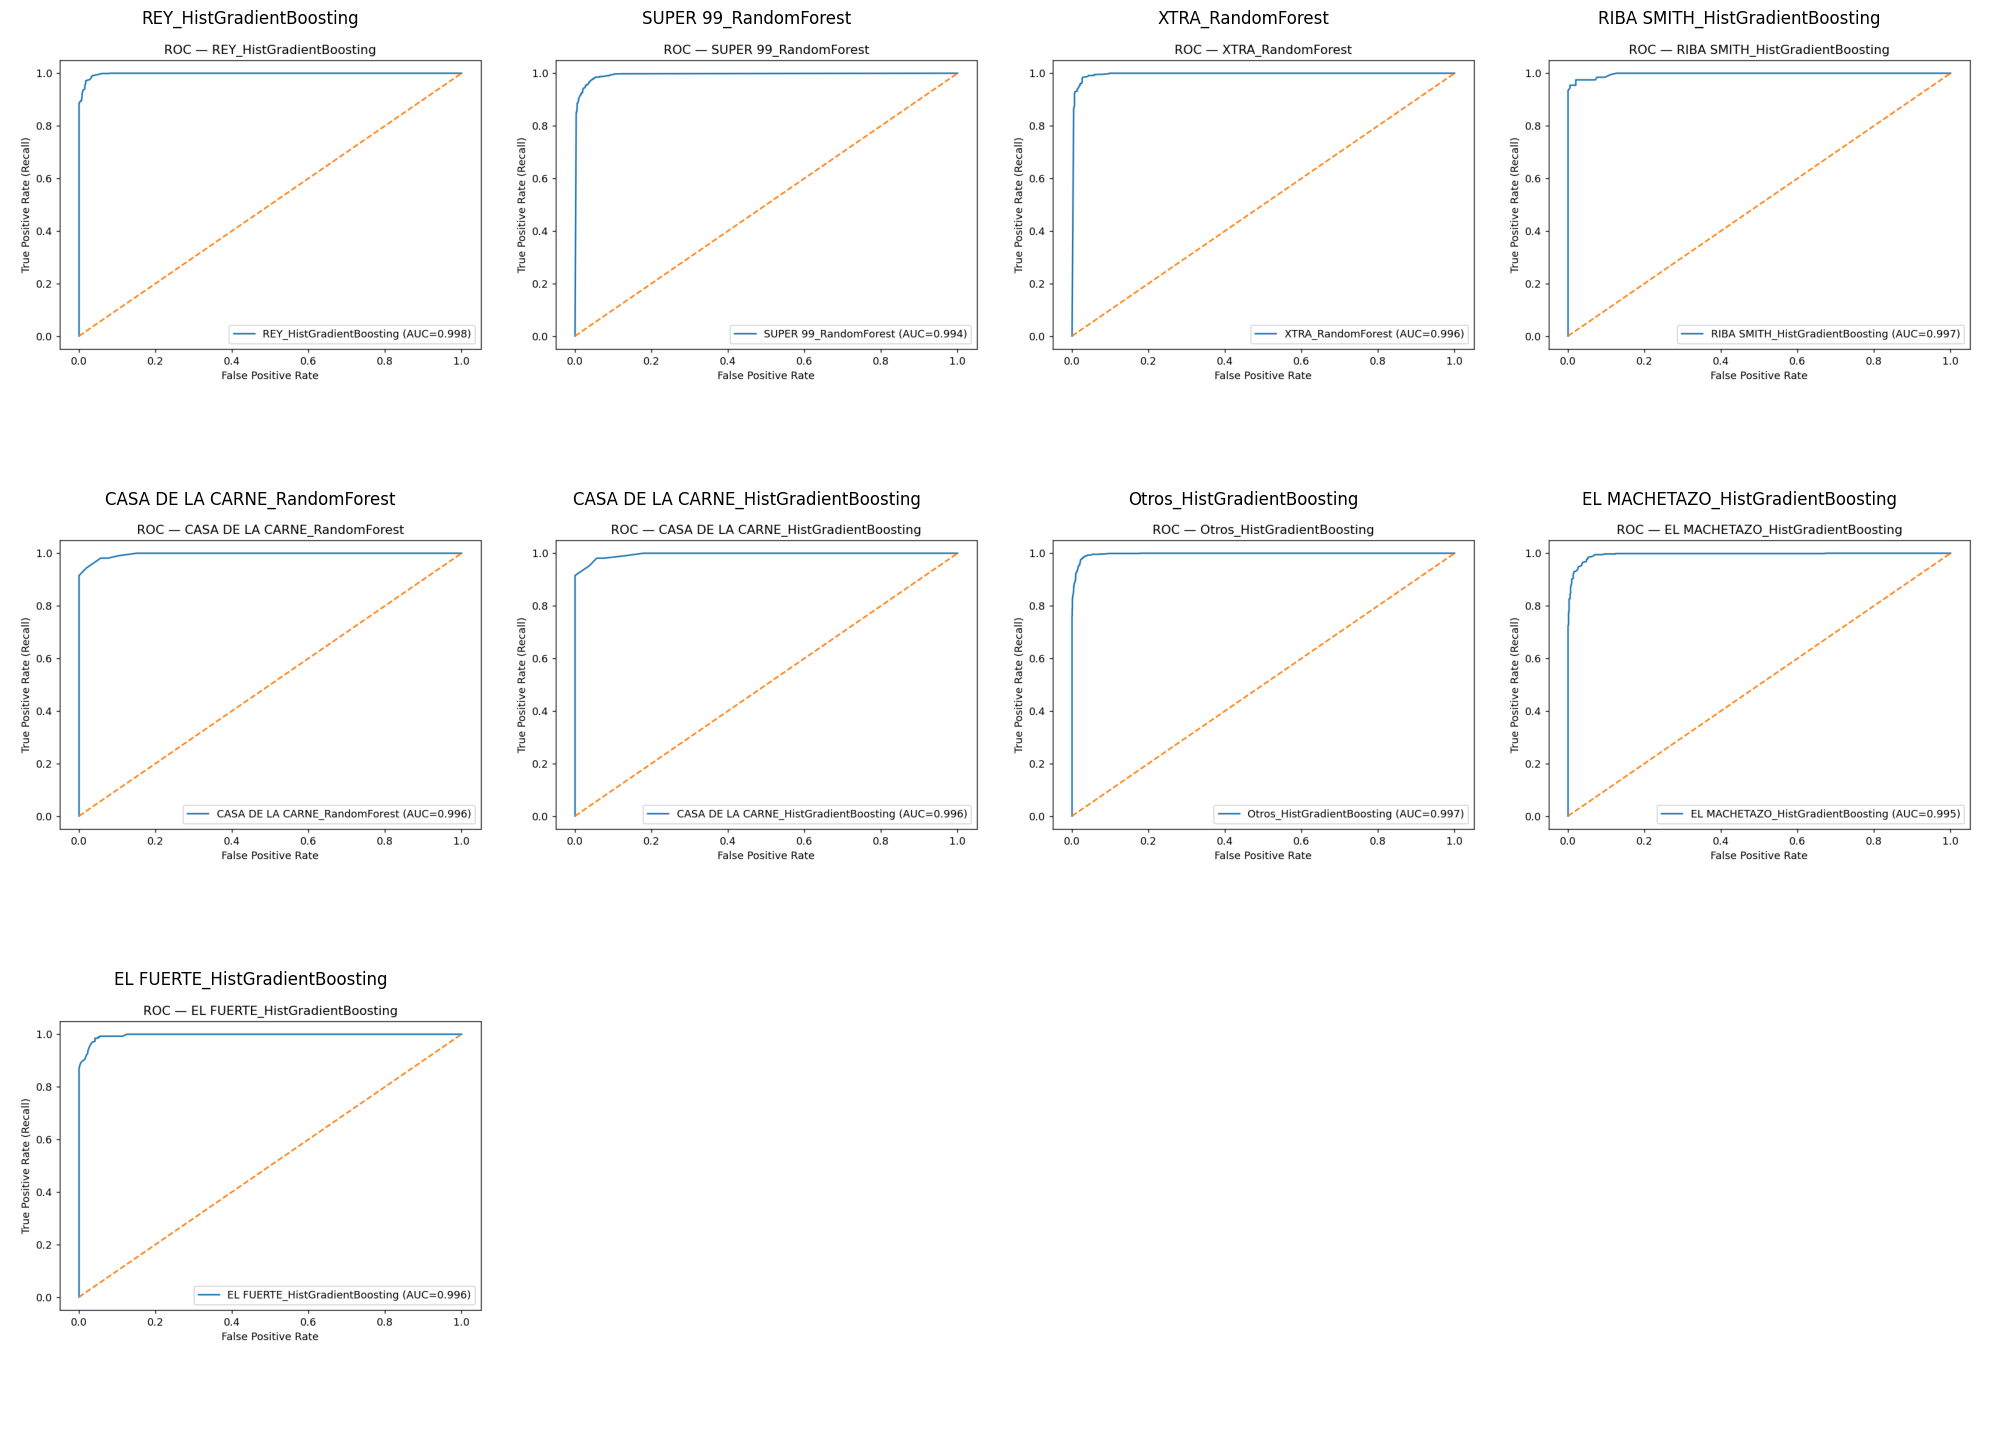

In [23]:

# Filtramos solo los mejores modelos
mejores_modelos = clasificacion_scores[clasificacion_scores["mejor"]]

# Lista de nombres de archivos de imagen basados en cadena y clasificador
imagenes = [
    f"ROC_{fila['cadena']}_{fila['clasificador']}.png"
    for _, fila in mejores_modelos.iterrows()
]

# Configuración del grid
n_cols = 4
n_imgs = len(imagenes)
n_rows = math.ceil(n_imgs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Asegurar que axes es siempre iterable en 2D
axes = axes.reshape(-1)

for ax, img_path in zip(axes, imagenes):
    img_path = os.path.join("../models/clasificacion/roc_curve", img_path)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path).replace("ROC_", "").replace(".png", ""))
    else:
        ax.axis("off")
        ax.set_title(f"No encontrado:\n{os.path.basename(img_path)}")

# Quitar ejes extra si sobran
for ax in axes[len(imagenes):]:
    ax.axis("off")

plt.tight_layout()
plt.show()